# Data Loading and Preprocessing

In [41]:
import pandas as pd

# Load the dataset
file_path = '//content/plays.csv'  # Replace with your file path
df = pd.read_csv(file_path)
print(df.columns)
# Check the columns to ensure all required columns are present
print(df.columns)

# If 'scoreDifference' is missing, calculate it based on home and away scores
if 'scoreDifference' not in df.columns:
    # Assuming 'homeScore' and 'awayScore' exist in the DataFrame
    df['scoreDifference'] = df['preSnapHomeScore'] - df['preSnapVisitorScore']  # Modify according to actual column names

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

# Feature Engineering

In [42]:
# Only focus on 4th down plays for the decision-making process
df_4th_down = df[df['down'] == 4]

# Add a 'go_for_it' column based on game context
df_4th_down['go_for_it'] = ((df_4th_down['yardsToGo'] < 5) & (df_4th_down['yardsGained'] < df_4th_down['yardsToGo']))

# Add a success column based on whether the yards gained on the play met the required yards to go
df_4th_down['success'] = df_4th_down['yardsGained'] >= df_4th_down['yardsToGo']

# Display the updated dataset with new columns
print(df_4th_down[['down', 'yardsToGo', 'yardsGained', 'go_for_it', 'success']].head())


     down  yardsToGo  yardsGained  go_for_it  success
47      4          1            1      False     True
120     4          4            0       True    False
224     4          2           -1       True    False
260     4          2           17      False     True
292     4         13            0      False    False


<ipython-input-42-6004fe11a955>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4th_down['go_for_it'] = ((df_4th_down['yardsToGo'] < 5) & (df_4th_down['yardsGained'] < df_4th_down['yardsToGo']))
<ipython-input-42-6004fe11a955>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4th_down['success'] = df_4th_down['yardsGained'] >= df_4th_down['yardsToGo']


# Binary Classification Model

In [43]:
# Features to include (you can add/remove columns based on your model objectives)
features = ['yardsToGo', 'expectedPointsAdded', 'scoreDifference', 'yardlineNumber', 'gameClock']

# Target variable: 'go_for_it' (whether the team decided to go for it or not)
X = df_4th_down[features]
y = df_4th_down['success']

# Handle categorical variables if needed (e.g., 'gameClock' might need transformation)
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a binary classifier, e.g., Logistic Regression or Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Accuracy: 0.953125
Confusion Matrix:
[[29  2]
 [ 1 32]]
Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.94      0.95        31
        True       0.94      0.97      0.96        33

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64



# Data Visualization

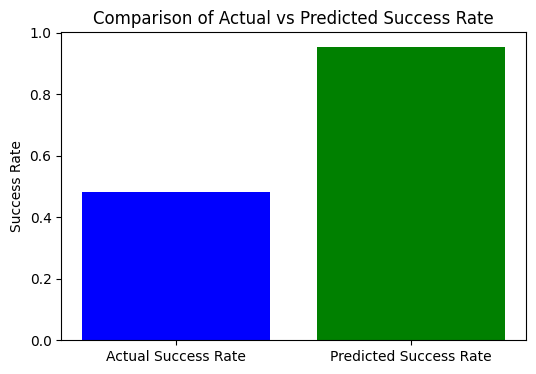

AUC Score: 0.9833822091886608


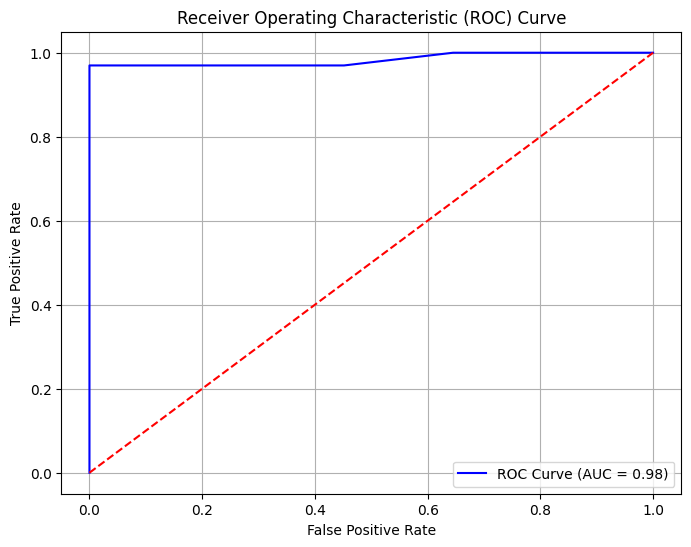

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Actual success rate
actual_success_rate = df_4th_down['success'].mean()

# Predicted success rate
predicted_success_rate = accuracy_score(y_test, y_pred)

# Plotting the comparison
plt.figure(figsize=(6, 4))
plt.bar(['Actual Success Rate', 'Predicted Success Rate'], [actual_success_rate, predicted_success_rate], color=['blue', 'green'])
plt.title('Comparison of Actual vs Predicted Success Rate')
plt.ylabel('Success Rate')
plt.show()

# Get the predicted probabilities for the positive class (i.e., success)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Print the AUC score
print(f"AUC Score: {auc_score}")
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guess
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
